In [1]:
import sys
from pathlib import Path
import re
import json
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.cm as cm
from matplotlib.container import BarContainer
from matplotlib.ticker import FuncFormatter
import polars as pl

def comma_formatter(x, pos):
    return f'{x:,.0f}'

def to_human(num, suffix="B"):
    if num % 1024 != 0:
        return f"{num}{suffix}"
    else:
        return pretty_fmt(num, suffix)

def pretty_fmt(num, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < 1024.0:
            return f"{num:.0f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

BENCHMARK_NAME="ior"
FIG_DIR = Path(f"../../fig/{BENCHMARK_NAME}").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)
def save(fig, name):
    for ext in ('png', 'eps'):
        fig.savefig(FIG_DIR / f'{name}.{ext}', bbox_inches = 'tight')
    # pass 

In [2]:
def load_ior_summary_list(json_file: Path):
    try:
        data = json.loads(json_file.read_text())
        return [
            {
                'Version': data['Version'],
                'Began': data['Began'],
                'Command line': data['Command line'],
                'Machine': data['Machine'],
                'Finished': data['Finished'],
                **{f'test_{k}': v for k, v in test.items() if k not in ["Results", "max", "Parameters", "Options"]},
                **{f"max_{k}": v for k, v in test["max"].items()},
                **{f"Parameters_{k}": v for k, v in test["Parameters"].items()},
                **{f"Options_{k}": v for k, v in test["Options"].items()},
                **{f'summary_{k}': v for k, v in data['summary'][index].items()},
                **{f'result_{k}': v for k, v in result.items()},
                'iorIteration': iteration,
            }
            for index, test in enumerate(data['tests'])
            for iteration, results in enumerate(test["Results"]) # iteration ?
            for result in results
        ]
    except Exception as e:
        print(f"Failed to load {json_file}, {e}")
        return []

In [3]:
RAW_BASEDIR = Path(f"../../raw/")

default_metadata = {}

# fmt: off
job_group = (
    ("ior-pmembb/2024.01.23-15.20.41-default", {"storageSystem": "PMEMBB"}),
    ("ior-pmembb/2024.01.23-15.22.18-default", {"storageSystem": "PMEMBB"}),
    ("ior-pmembb/2024.01.24-12.44.18-default", {"storageSystem": "PMEMBB"}),  # remain 100 node job
    ("ior-pmembb/2024.03.13-11.17.33-47008",   {"storageSystem": "PMEMBB"}),
    ("ior-lustre/2024.02.19-12.11.41-default", {}),
    ("ior-lustre/2024.03.08-13.32.07-100", {}),
    ("ior-unifyfs/2024.02.25-00.47.21-default", {}),
    ("ior-unifyfs/2024.03.08-13.28.47-100", {}),
    ("ior-unifyfs/2024.03.13-11.16.29-default", {}),
    ("ior-chfs/2024.03.13-10.47.36-ppn8-100", {}),
    ("ior-chfs/2024.03.13-10.54.26-ppn8", {}),
    ("ior-beeond/2024.03.10-13.02.17-default", {}),
    ("ior-beeond/2024.03.13-11.01.27-default", {}),
)
# fmt: on

re_timestamp = re.compile(
    r"([0-9]{4})\.([0-9]{2})\.([0-9]{2})-([0-9]{2})\.([0-9]{2})\.([0-9]{2})"
)


def parse_job_start_timestamp(job_dir: Path):
    m = re_timestamp.search(str(job_dir))
    if m:
        return m.group()
    else:
        return None


re_runid = re.compile(r"_([0-9]+)\.json")


def get_runid(file: Path):
    m = re_runid.search(str(file))
    if m:
        return int(m.group(1))
    else:
        return None


def load_job_params(job_dir: Path, runid: int):
    try:
        return json.loads((job_dir / f"job_params_{runid}.json").read_text())
    except Exception as e:
        print(f"Failed to load job_params{runid}.json, {e}")
        return {}


df_src = (
    pl.DataFrame(
        [
            {
                **default_metadata,
                "job_start": parse_job_start_timestamp(job_dir),
                **load_job_params(job_dir, get_runid(ior_summary_file)),
                **ior_summary,
                **metadata,
            }
            for job_group_dir, metadata in job_group
            for job_dir in (RAW_BASEDIR / job_group_dir).glob("*")
            if job_dir.is_dir()
            for ior_summary_file in job_dir.glob("ior_summary_*.json")
            for ior_summary in load_ior_summary_list(ior_summary_file)
        ]
    )
    .with_columns(
        odirect=pl.col("Command line").str.contains("--posix.odirect"),
        strided=pl.col("summary_transferSize") == pl.col("summary_blockSize"),
    )
    .rename(
        {
            "summary_bwMaxMIB": "bw",
            "summary_MeanTime": "time",
            "summary_segmentCount": "segmentCount",
            "summary_blockSize": "blockSize",
            "summary_transferSize": "transferSize",
            "summary_operation": "operation",
            "Parameters_filePerProc": "fpp",
            "Parameters_reorderTasks": "reorder",
            "summary_API": "api",
            "result_access": "access",
            "result_bwMiB": "bwMiB",
            "result_openTime": "openTime",
            "result_wrRdTime": "wrRdTime",
            "result_closeTime": "closeTime",
            "result_totalTime": "totalTime",
        }
    )
    .with_columns(
        fpp=pl.col("fpp").cast(pl.Boolean),
        reorder=pl.col("reorder").cast(pl.Boolean),
        bwGB=pl.col("bwMiB") * 2**20 / 10**9,
    )
    .with_columns(
        pl.when(pl.col("access") == "write")
        .then(pl.lit("Write"))
        .when((pl.col("access") == "read") & pl.col("reorder"))
        .then(pl.lit("Read (remote)"))
        .when((pl.col("access") == "read") & pl.col("reorder") == False)
        .then(pl.lit("Read (local)"))
        .otherwise(pl.lit("Unknown"))
        .alias("label"),
    )
)

Failed to load ../../raw/ior-pmembb/2024.01.23-15.20.41-default/2024.01.24-09.00.05-166928.nqsv-100/ior_summary_13.json, Expecting value: line 1 column 1 (char 0)
Failed to load ../../raw/ior-pmembb/2024.03.13-11.17.33-47008/2024.03.13-12.13.15-182927.nqsv-32/ior_summary_3.json, Expecting value: line 1 column 1 (char 0)
Failed to load ../../raw/ior-pmembb/2024.03.13-11.17.33-47008/2024.03.13-11.50.10-182922.nqsv-4/ior_summary_3.json, Expecting value: line 1 column 1 (char 0)
Failed to load ../../raw/ior-pmembb/2024.03.13-11.17.33-47008/2024.03.13-14.47.13-182932.nqsv-100/ior_summary_3.json, Expecting value: line 1 column 1 (char 0)
Failed to load ../../raw/ior-pmembb/2024.03.13-11.17.33-47008/2024.03.13-12.04.48-182926.nqsv-16/ior_summary_3.json, Expecting value: line 1 column 1 (char 0)
Failed to load ../../raw/ior-pmembb/2024.03.13-11.17.33-47008/2024.03.13-11.26.05-182917.nqsv-1/ior_summary_3.json, Expecting value: line 1 column 1 (char 0)
Failed to load ../../raw/ior-pmembb/2024.03

In [4]:
(
    df_src
    .select(
        "storageSystem",
        "fpp",
        "bwGB",
        "access",
        "reorder",
        "label",
        "lustre_stripe_count",
    )
    .filter(pl.col("storageSystem") == "PMEMBB", pl.col("lustre_stripe_count") != 1)
)

storageSystem,fpp,bwGB,access,reorder,label,lustre_stripe_count
str,bool,f64,str,bool,str,i64


In [5]:
NETWORK_LIMIT_PER_NODE = 200 / 8
PMEM_READ_LIMIT_PER_NODE = 80.309346 * 2**30 / 10**9
PMEM_WRITE_LIMIT_PER_NODE = 25.836094 * 2**30 / 10**9

print(f"PMEM_READ_LIMIT_PER_NODE: {PMEM_READ_LIMIT_PER_NODE} GB/s")
print(f"PMEM_WRITE_LIMIT_PER_NODE: {PMEM_WRITE_LIMIT_PER_NODE} GB/s")
print(f"NETWORK_LIMIT_PER_NODE: {NETWORK_LIMIT_PER_NODE} GB/s")

def network_limit(nnodes):
    return nnodes * NETWORK_LIMIT_PER_NODE

def pmem_read_limit(nnodes):
    return nnodes * PMEM_READ_LIMIT_PER_NODE

def pmem_write_limit(nnodes):
    return nnodes * PMEM_WRITE_LIMIT_PER_NODE

PMEM_READ_LIMIT_PER_NODE: 86.23150365828711 GB/s
PMEM_WRITE_LIMIT_PER_NODE: 27.741294696595457 GB/s
NETWORK_LIMIT_PER_NODE: 25.0 GB/s


read True


nnodes,Lustre,BeeOND,CHFS,UnifyFS,PEANUTS
i64,f64,f64,f64,f64,f64
2,8.476103,18.512007,27.333108,0.613928,48.580417
4,16.726129,34.870098,47.473784,1.205152,97.089789
8,33.028621,67.029253,88.43597,2.370566,193.858457
16,50.018964,119.576244,169.383707,4.751059,387.072398
32,49.035771,211.903184,333.926856,9.476074,773.253691
64,48.870996,323.199884,662.325881,14.542146,1541.638842
100,50.695758,712.177709,1028.557438,13.398797,2387.744699


nnodes,256B,512B,1KB,2KB,4KB,8KB,16KB,32KB,47008B,64KB,128KB,256KB,512KB,1MB,2MB
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,4.887663,9.309238,17.252629,31.21662,44.116229,47.178962,47.957393,48.437253,48.482843,48.52257,48.568824,48.548412,48.580417,48.57765,48.578961
4,9.196967,17.511601,27.81904,55.099902,86.048086,94.26105,95.743169,96.725825,95.566129,96.025318,96.939422,97.089789,96.910504,96.951911,96.945178
8,16.257175,30.837754,52.315632,101.281132,171.186583,187.906674,191.444053,193.212062,190.675,191.722674,193.701077,193.858457,193.848517,193.775742,193.637612
16,35.857595,68.024477,108.352224,218.958258,342.805684,375.345327,382.671262,386.295563,381.648661,384.274221,386.941289,386.758058,387.072398,386.819969,386.882161
32,61.436965,116.414096,192.563174,383.170215,636.516599,736.027829,759.59896,769.05671,760.637662,766.485555,768.784026,773.253691,772.035052,771.867374,770.055386
64,122.353868,232.12067,383.284577,772.236503,1279.679655,1489.254594,1522.365739,1537.97575,1519.374561,1524.865183,1539.120074,1541.638842,1537.505153,1540.232576,1540.631507
100,192.169223,365.1711,605.677897,1179.05997,1960.132553,2290.634927,2344.225928,2382.250783,2360.679532,2359.441943,2379.961711,2387.744699,2384.772966,2381.713974,2385.701405


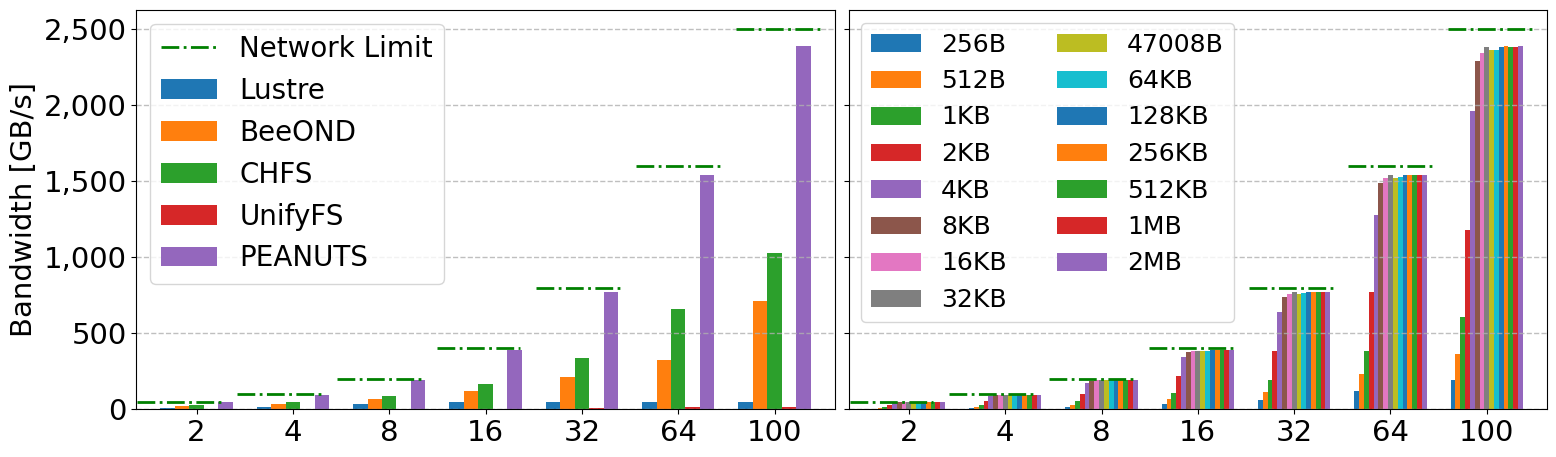

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


read False


nnodes,Lustre,BeeOND,CHFS,UnifyFS,PEANUTS
i64,f64,f64,f64,f64,f64
1,4.227516,8.953188,18.737703,0.320603,83.593321
2,8.406153,18.508202,27.309305,0.641552,169.882509
4,16.900505,34.822606,47.530438,1.281769,328.375277
8,33.08239,66.990708,88.318357,2.561366,654.396892
16,50.175458,131.169084,168.341503,5.111022,1303.361282
32,49.087766,258.663676,336.107214,10.204339,2550.720071
64,48.936631,510.092902,663.865516,20.410101,5139.174919
100,51.260485,792.676442,1031.533672,31.804309,7750.59563


nnodes,256B,512B,1KB,2KB,4KB,8KB,16KB,32KB,47008B,64KB,128KB,256KB,512KB,1MB,2MB
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,59.937796,69.043245,68.590326,69.465175,76.338659,80.478184,81.830313,82.759076,82.159474,82.921406,83.200613,83.491632,83.593321,82.650955,72.410097
2,119.938596,139.48253,140.211936,140.756915,154.256532,162.822235,166.431911,167.684872,163.665659,169.125535,169.882509,168.711783,169.819335,168.095379,147.117471
4,234.150514,268.633205,275.360832,275.415709,299.782369,317.136574,321.370639,325.069035,325.034212,326.61311,327.803015,328.201745,328.375277,326.189937,284.807355
8,464.785043,537.723202,545.967425,552.34778,597.86113,626.206973,635.562124,648.1264,646.200201,649.463634,654.396892,651.531949,651.082264,645.09786,566.031306
16,911.391293,1068.26147,1083.172753,1086.24274,1189.89636,1256.471741,1268.877118,1283.556422,1281.530173,1283.088861,1276.106926,1293.216576,1303.361282,1281.268593,1115.760961
32,1811.834229,2109.7825,2152.598944,2141.145805,2337.090638,2486.21837,2463.97895,2546.018171,2545.508961,2545.860828,2510.047941,2544.071139,2550.720071,2548.126221,2209.53138
64,3624.566264,4213.781161,4280.375483,4293.161774,4662.839176,4892.790739,5010.175516,5073.063752,5058.711286,5030.160458,4818.607626,5102.304544,5139.174919,4990.550762,4400.692407
100,5479.364182,6442.494305,6530.48286,6772.440746,7039.80865,7424.626788,7527.117014,7686.149692,7644.985414,7740.061536,7750.59563,7617.305227,7722.492855,7531.99826,6698.95186


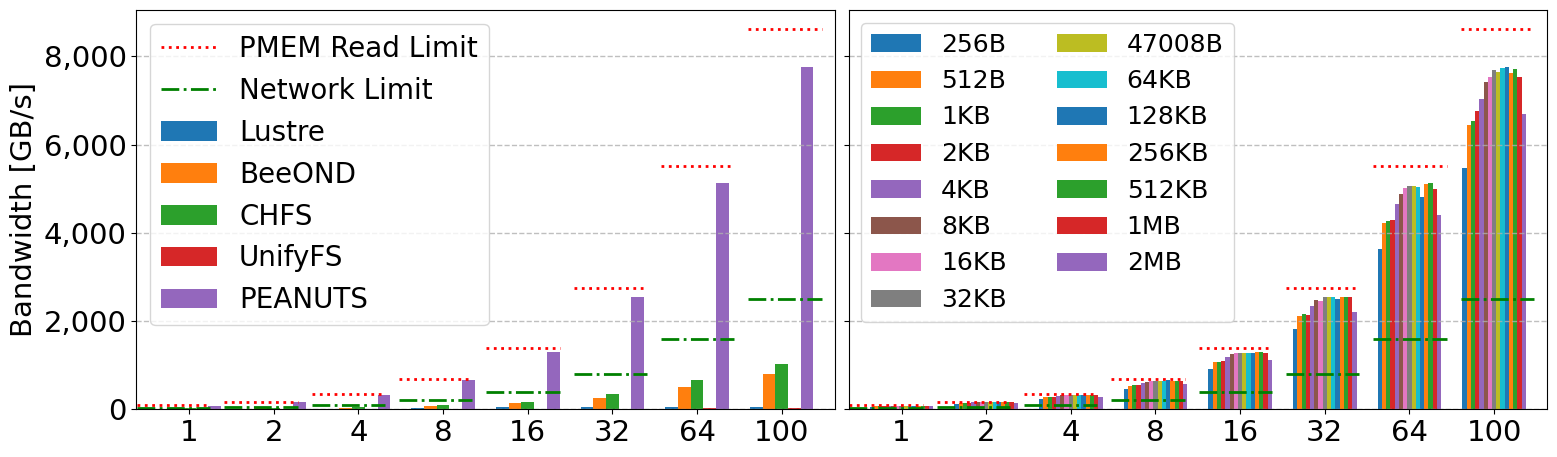

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


write False


nnodes,Lustre,BeeOND,CHFS,UnifyFS,PEANUTS
i64,f64,f64,f64,f64,f64
1,2.197092,3.499816,7.009261,12.277756,26.47033
2,4.401067,5.405237,10.870913,24.542533,52.864778
4,8.718904,9.543697,21.071447,48.983521,103.653041
8,17.154205,18.238852,42.241413,97.436258,201.975732
16,30.660943,36.118496,80.481491,188.030302,398.962319
32,38.64192,70.800639,157.353946,368.574771,799.270147
64,40.398911,129.520148,316.677678,724.160303,1594.01412
100,38.95919,198.484181,481.825975,1118.629131,2470.947638


nnodes,256B,512B,1KB,2KB,4KB,8KB,16KB,32KB,47008B,64KB,128KB,256KB,512KB,1MB,2MB
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,26.309229,26.47033,26.261931,26.210188,25.861533,25.107555,25.016613,24.969357,24.405955,25.060271,24.991053,25.017081,24.987864,25.016087,25.594842
2,52.662124,52.864778,52.591439,52.308009,51.740618,50.263043,50.051812,49.739472,48.931415,50.117499,49.972404,50.045342,49.983904,49.800519,51.164929
4,102.783174,102.664157,102.667894,103.653041,102.497893,99.700032,99.313193,99.027769,97.518366,99.604441,99.354583,99.270554,99.24407,99.503459,101.575146
8,197.806874,199.337269,199.326204,200.393265,201.975732,197.858709,194.981057,196.817743,194.34351,197.690614,197.231901,197.348567,197.349616,197.149034,201.308884
16,394.192824,396.783696,398.384713,398.962319,396.06214,389.704063,389.283534,388.792888,388.167277,389.390406,389.563799,388.62193,389.222869,389.262743,394.061112
32,787.182607,792.990882,797.220423,799.270147,794.04256,778.365695,773.940748,776.469187,775.017661,776.741828,774.380148,775.142041,776.52263,775.872119,790.893819
64,1557.042196,1582.708532,1588.982252,1594.01412,1577.847059,1547.341789,1546.420566,1540.161204,1535.153949,1546.250892,1543.979352,1536.456955,1543.428012,1544.112552,1562.943721
100,2401.679537,2462.997753,2470.947638,2465.055903,2463.853422,2417.99388,2408.448315,2411.629479,2388.70233,2414.653564,2408.929476,2405.065374,2408.673904,2406.934527,2429.826425


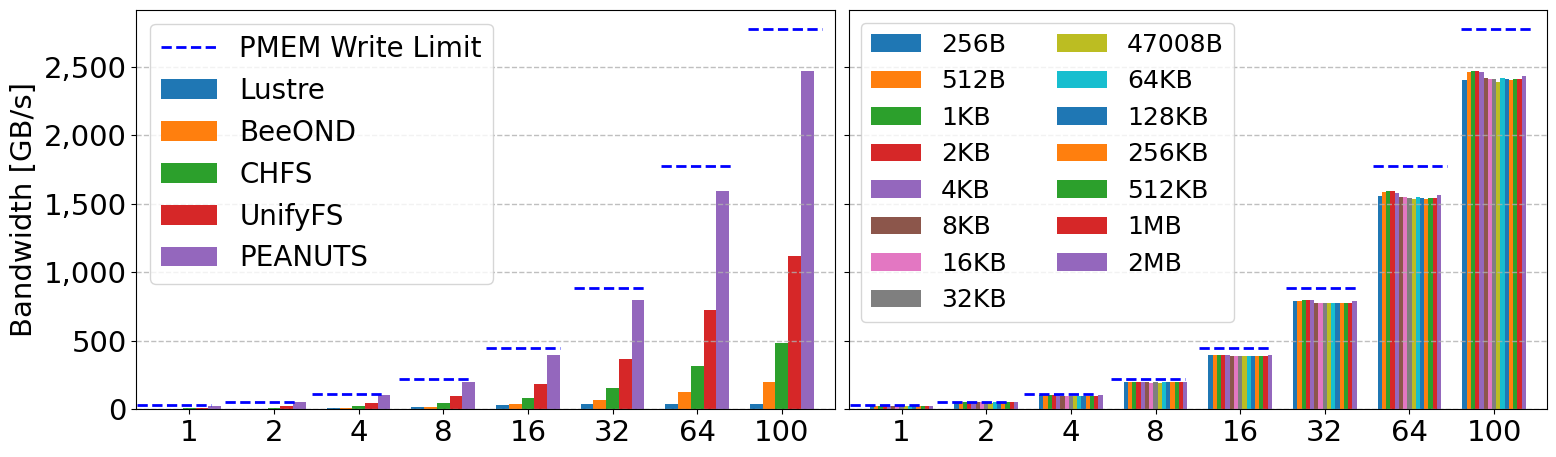

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [23]:
plt.rcParams.update({"font.size": 21})

group_by_columns = [
    "storageSystem",
    "access",
    "reorder",
    "nnodes",
]
df = (
    df_src.lazy()
    .filter(
        (
            (pl.col("storageSystem") == "PMEMBB")
            & (pl.col("spack_env_name") != "mpiio-pmembb")
        ).not_(),
        pl.col("access") != "remove",
        (
            (pl.col("access") == "read")
            & (pl.col("reorder") == True)
            & pl.col("nnodes")
            == 1
        ).not_(),
        pl.col("nnodes") <= 100,
    )
    .group_by(group_by_columns + ["transferSize"])
    .agg(pl.max("bwGB"))
    .collect()
)
# display(df)


for (access, remote), df_sub in df.group_by(("access", "reorder")):
    print(access, remote)

    ylim=(0, df_sub.select(pl.max("bwGB")).item())

    fig, axes = plt.subplots(ncols=2, figsize=(16, 5), sharey=True)
    fig.patch.set_alpha(1)
    ax0 = (
        df_sub.group_by(group_by_columns)
        .agg(pl.max("bwGB"))
        .pivot(values="bwGB", index="nnodes", columns="storageSystem")
        .rename({"PMEMBB": "PEANUTS"})
        .select(["nnodes", "Lustre", "BeeOND", "CHFS", "UnifyFS", "PEANUTS"])
        .sort("nnodes")
        .pipe(lambda df: (display(df), df)[-1])
        .to_pandas()
        .set_index("nnodes")
        .plot(
            ax=axes[0],
            kind="bar",
            xlabel="",
            ylabel="Bandwidth [GB/s]",
            rot=0,
            width=0.75,
        )
    )
    ax0.yaxis.set_major_formatter(FuncFormatter(comma_formatter))
    ax0.grid(which="major", axis="y", alpha=0.8, linestyle="--", linewidth=1)

    ax1 = (
        df_sub.filter(pl.col("storageSystem") == "PMEMBB")
        .with_columns(
            transferSizeH=pl.col("transferSize").map_elements(to_human, pl.String),
        )
        .sort(["nnodes", "transferSize"])
        .pivot(values="bwGB", index="nnodes", columns="transferSizeH")
        .sort("nnodes")
        .pipe(lambda df: (display(df), df)[-1])
        .to_pandas()
        .set_index("nnodes")
        .plot(
            ax=axes[1],
            kind="bar",
            xlabel="",
            ylabel="Bandwidth [GB/s]",
            rot=0,
            width=0.75,
        )
    )
    ax1.grid(which="major", axis="y", alpha=0.8, linestyle="--", linewidth=1)
    # ax1.set_ylim(ax0.get_ylim())
    # ax0.set_ylim(ylim)
    # ax1.set_ylim(ylim)

    nnode_list = [int(t.get_text()) for t in ax0.get_xaxis().get_ticklabels()]
    if access == "write":
        for xtick, nnodes in enumerate(nnode_list):
            hline_params = {
                "y": pmem_write_limit(nnodes),
                "xmin": (xtick + 0.01) / len(nnode_list),
                "xmax": (xtick + 0.85) / len(nnode_list),
                "color": "blue",
                "linestyle": "--",
                "linewidth": 2,
            }
            ax0.axhline(**hline_params)
            ax1.axhline(**hline_params)
        ax0.plot([], [], linestyle="--", color="blue", label="PMEM Write Limit", linewidth=2)
        # ax1.plot([], [], linestyle="--", color="blue", label="PMEM Write Limit")
        ax0.set_ylim(0, pmem_write_limit(nnode_list[-1]) * 1.05)
    else:
        for xtick, nnodes in enumerate(nnode_list):
            hline_params = {
                "y": network_limit(nnodes),
                "xmin": (xtick + 0.01) / len(nnode_list),
                "xmax": (xtick + 0.85) / len(nnode_list),
                "color": "green",
                "linestyle": "-.",
                "linewidth": 2,
            }
            ax0.axhline(**hline_params)
            ax1.axhline(**hline_params)
        ax0.set_ylim(0, network_limit(nnode_list[-1]) * 1.05)
        if not remote:
            for xtick, nnodes in enumerate(nnode_list):
                hline_params = {
                    "y": pmem_read_limit(nnodes),
                    "xmin": (xtick + 0.01) / len(nnode_list),
                    "xmax": (xtick + 0.85) / len(nnode_list),
                    "color": "red",
                    "linestyle": ":",
                    "linewidth": 2,
                }
                ax0.axhline(**hline_params)
                ax1.axhline(**hline_params)
            ax0.plot([], [], linestyle=":", color="red", label="PMEM Read Limit", linewidth=2)
            # ax1.plot([], [], linestyle=":", color="red", label="PMEM Read Limit")
            ax0.set_ylim(0, pmem_read_limit(nnode_list[-1]) * 1.05)
        ax0.plot([], [], linestyle="-.", color="green", label="Network Limit", linewidth=2)
        # ax1.plot([], [], linestyle="-.", color="green", label="Network Limit")

    ax1.set_ylim(ax0.get_ylim())
    ax0.legend(title="", fontsize=20)
    ax1.legend(title="", fontsize=18, ncols=2)

    plt.tight_layout()
    fig.subplots_adjust(wspace=0.02)
    plt.show()
    save(fig, f"ior_bw_{access}_{'remote' if remote else 'local'}_wide")